In [1]:
%matplotlib notebook

import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import subprocess
import shutil

from IPython.display import display, Image
# from EAZY_fun import *
from scipy import interpolate
from scipy import integrate
from astropy.io import ascii
from astropy.wcs import WCS
from matplotlib.ticker import AutoMinorLocator
from synphot import SourceSpectrum, etau_madau
from synphot.models import ConstFlux1D
from synphot.models import Empirical1D
import glob
#import sncosmo


In [2]:
way2 = 'goodss_3dhst.v4.1.cat'
way  = 'tweak_cosmos_v4/'
name = 'eazy_v1.1_sed'

In [3]:
# Load all model spectra and main catalog

list =  glob.glob(way + 'eazy*.dat')
main_cat = np.genfromtxt(way2, skip_header=2)  #[200:210]

# FUNCTIONS AND CONSTANTS

In [4]:
# Number of object 
id = 28720


# Cosmological constants
Omega_M = 0.2726             # Density of matter
Omega_K =  0.0               # Density of curvature
Omega_L = 0.7274             # Density of dark energy
h = 0.704

# For reference
c = 2.9927e10
pi = 3.14159265


# Collection of additional distance functions  
E   = lambda x: 1/np.sqrt(Omega_M*np.power(1+x,3)+Omega_L+Omega_K*np.power(1+x,2))
D_c = lambda x: (9.26e27/h)*integrate.quad(E, 0, x)[0]                                     # In centimeters
D_m = lambda x: D_c(x)
D_A = lambda x: D_m(x)/(1+x)
D_L = lambda x: np.power(1+x, 2) * D_A(x)

In [5]:
# The function of shifting the wavelength and shift amplitude of the flux
def func_1(z, n, x, y):
    l_mod  = (1+z)*x
    mod_flux = n*y
    return l_mod, mod_flux

In [6]:
# A function that takes into account the absorption and response function
def chi2(z, n, lcii, x, y, fil, toplot=False):
    
    # Find the template corresponding to our z and n
    l_obs2, moh = func_1(z, n, x, y)

    lcii = np.array(lcii)

    # Sorting
    moh = moh[np.argsort(l_obs2)]
    lcii = lcii[np.argsort(lcii)]

    # Add the absorption for objects with a large redshift
    extcurve = etau_madau(l_obs2, z)
    sp_ext = moh * extcurve(l_obs2)

    sp_ext = sp_ext[np.argsort(l_obs2)]
    l_obs2 = l_obs2[np.argsort(l_obs2)]

    # Add response function for all filters
    for i in range(len(fil)):
        res, n = get_filter_by_id(fil[i])
        
        # Load lambda and flux from filter response function
        x_res = res[:, 1]
        y_res = res[:, 2]

        
        # To avoid zero values
        x_filt = np.array(x_res[np.where(y_res>0.2)])
        y_filt = np.array(y_res[np.where(y_res>0.2)])

        # Load template lambda
        xx_tem = l_obs2[np.where((l_obs2 >= np.min(x_filt)) & (l_obs2 <= np.max(x_filt)))[0]]
        # yy_tem = tem_fl[np.where( (tem_lam>=min(res[:,1])) & (tem_lam<=max(res[:,1])))[0]]

        func = np.interp(xx_tem, x_filt, y_filt)


        sp_ext[np.where( ( l_obs2 >= np.min(x_filt) ) & ( l_obs2 <= np.max(x_filt) ) )[0]] *= func
        
        # Where we must have zero flux
        sp_ext[np.where((l_obs2 < np.min(x_filt)) & (l_obs2 > np.max(x_filt)))[0]] == 0
        
    flo = np.interp(lcii, l_obs2, sp_ext)



    return flo


In [7]:
# It return name and response function for each filter by id in num_fil
def get_filter_by_id(id):
    temp = np.array([a[0] for a in filters_info]).astype(int)
    name = filters_info[np.where(temp == id)[0][0]][1]
    names = np.array([a[1] for a in filters_names])
    #   print name
    return filters[np.where(name == names)[0][0]], name

# DATA

In [8]:
# The column numbers of the flux in the main catalog

#flux_cat = [9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,\
#           78,81,84,87,89,91,93,95,97,99,101,103,105,107,109,111,113]

fl1 = np.linspace(9, 87, 27)
fl2 = np.linspace(89, 113, 13)
num_fc = np.hstack((fl1, fl2))


# The column numbers of the errors in the main catalog

#error_flux_cat = [10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58,61,64,67,70,\
#                 73,76,79,82,85,88,90,92,94,96,98,100,102,104,106,108,110,112,114]
    
efl1 = np.linspace(10, 88, 27)
efl2 = np.linspace(90, 114, 13)
num_efc = np.hstack((efl1, efl2))


fil_cat = ['F160W', 'U38', 'U', 'F435', 'B', 'V', 'F606cand', 'F606W', 'R', 'Rc','F775W', 'I', 'F814Wcand',\
          'F850LP', 'F850LPcand', 'F125W', 'J', 'tenisJ', 'F140W', 'H', 'tenisK', 'Ks', 'IRAC1', \
          'IRAC2', 'IRAC3', 'IRAC4', 'IA427', 'IA445', 'IA505', 'IA527', 'IA550', 'IA574', 'IA598',\
          'IA624', 'IA651', 'IA679', 'IA738', 'IA767', 'IA797', 'IA856']

# Central wavelengths of filters

lambd = np.array(([1.5396, 0.3637, 0.3750, 0.4318, 0.4563, 0.5396, 0.5921, 0.5919, 0.6443, 0.6517,\
                   0.7693, 0.7838, 0.8057, 0.9036, 0.9033, 1.2471, 1.2356, 1.2530, \
                   1.3924, 1.6496, 2.1574, 2.1667, 3.5569, 4.5020, 5.7450, 7.9158, 0.4260, 0.4443, 0.5061, 0.5259,\
                   0.5495, 0.5763,  0.6007, 0.6231, 0.6498, 0.6782, 0.7359, 0.7680, 0.7966, 0.8565]))


In [9]:
# Spectrum from the catalog hst
flux_c = []
erflu_c = []
filt = []

for i in range(len(main_cat[0, :])):
    for j in range(len(num_fc)):
        if (i == num_fc[j]) & (main_cat[id - 1, i] > 0):
            flux_c.append(main_cat[id - 1, i])
            erflu_c.append(main_cat[id - 1, int(num_efc[j])])
            filt.append(j)

# Translate the wavelength into angstroms
lci = lambd[filt] * 10 ** 4

# Reproduce to a good type
flux_c = np.array(flux_c)
erflu_c = np.array(erflu_c)

# Translate the flow into nano Jansky
flux_c = [flux_c[i] * 10 ** (2.56) for i in range(len(flux_c))]
erflu_c = erflu_c * 10**2.56

# Reproduce to a good type again
flux_c = np.array(flux_c)
erflu_c = np.array(erflu_c)

# Sorting
flux_c = flux_c[np.argsort(lci)]
erflu_c = erflu_c[np.argsort(lci)]
lci = lci[np.argsort(lci)]

# TRANSPOTION FUNCTION

In [10]:
fname = 'goodss_3dhst.v4.1.translate'
filt_list = np.genfromtxt(fname, dtype=None)


fil = []
num_fil = []
for i, j in zip(filt_list[:, 1], np.linspace(0, 87, 88)):
    if j % 2 == 0:
        num_fil.append(np.array(i[1:]).astype(int))
        # print(np.array(i[1:]).astype(int))

        
for i, j in zip(filt_list[:, 0], np.linspace(0, 87, 88)):
    if j % 2 == 0:
        fil.append(np.array(i[2:]).astype(str))
        

num_fil = np.array(num_fil)
fil = np.array(fil)

# Filters and their numbers
fil = fil[np.argsort(num_fil)]
num_fil = num_fil[np.argsort(num_fil)]

# Delete filters that are not in the article
hi = [19, 20, 29, 33]
#print(np.delete(num_fil, hi))
#print(np.delete(fil, hi))

In [11]:
filters_info = []
for line in open('FILTER.RES.latest.info', 'r'):
    filters_info.append(np.array(line.split()))
filters_info = np.array(filters_info)

In [12]:
temp_filters = open('FILTER.RES.latest', 'r')
filters = []
filters_names = []
first = True

l = 0
for line in temp_filters:

    if line[0] == ' ':

        if not first:
            filters.append(np.array(temp))
            l += 1

        first = False
        filters_names.append(line.split())
        temp = []

    else:
        temp.append(np.array(line.split()).astype('float'))
        
# filters - include response function for each filter
# filters_name - include all filters name

filters = np.array(filters)
filters_names = np.array(filters_names)

# MAIN CYCLE

(200, 150)


<IPython.core.display.Javascript object>


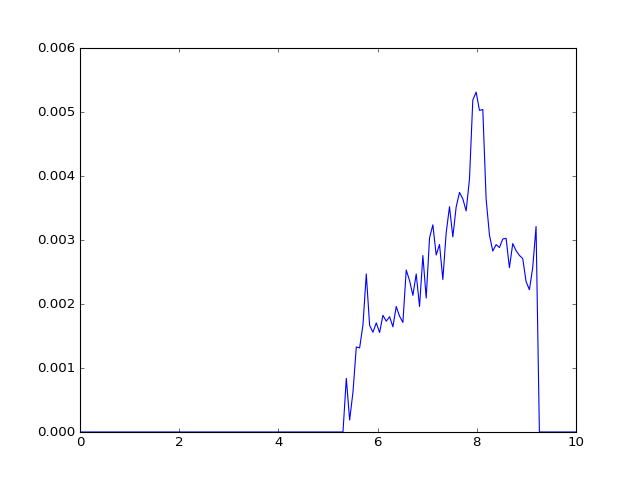

In [75]:
# How many points we want for z and n
z_list = np.linspace(0,10,150)
n_list = np.logspace(-1,3,200)

L = np.ones((len(n_list), len(z_list)))
print(np.shape(L))

k=2
# Data from template
x = np.genfromtxt(list[k])[:, 0]
y = np.genfromtxt(list[k])[:, 1]

# The main cycle

for j in range(len(z_list)):
#         print(j)
        fitz = chi2(z_list[j], 1., lci, x, y, num_fil)
        for i in range(len(n_list)):
            #       print(i,j)
            L[i,j] = np.sum((flux_c - n_list[i]*fitz) ** 2 / (erflu_c ** 2))
            
H = np.amin(L, axis = 0)
PZ = H


plt.close()
plt.plot( z_list, np.exp(-(PZ)))
plt.show()

<IPython.core.display.Javascript object>


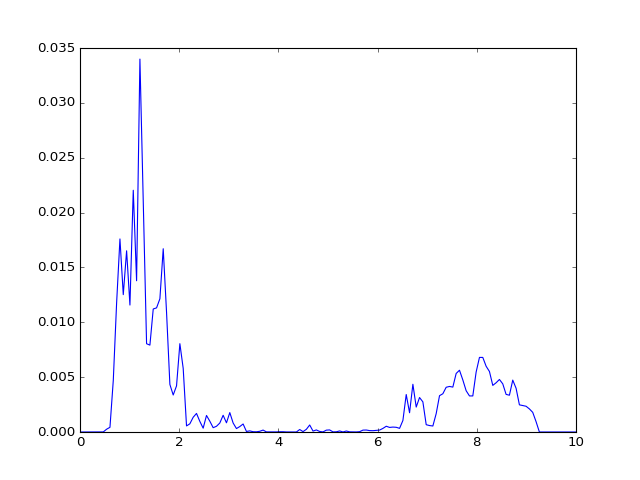

In [76]:
L = np.ones((len(n_list), len(z_list)))
k=0

x = np.genfromtxt(list[k])[:, 0]
y = np.genfromtxt(list[k])[:, 1]


for j in range(len(z_list)):
#         print(j)
        fitz = chi2(z_list[j], 1., lci, x, y, num_fil)
        for i in range(len(n_list)):
            #       print(i,j)
            L[i,j] = np.sum((flux_c - n_list[i]*fitz) ** 2 / (erflu_c ** 2))
            
H = np.amin(L, axis = 0)
PZ = H


plt.close()
plt.plot( z_list, np.exp(-(PZ)))
plt.show()

<IPython.core.display.Javascript object>


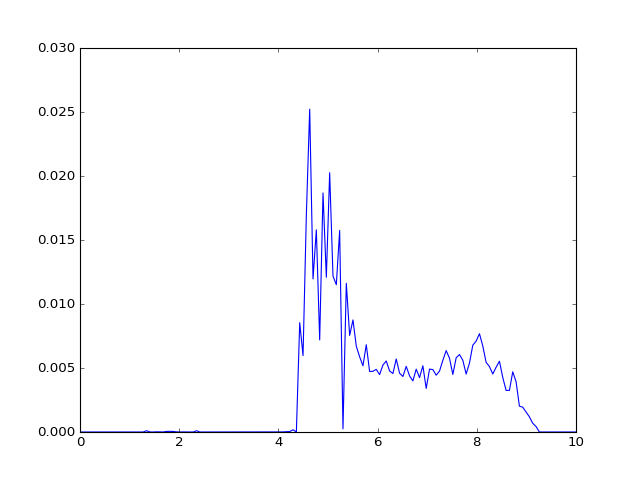

In [77]:
L = np.ones((len(n_list), len(z_list)))
k=1

x = np.genfromtxt(list[k])[:, 0]
y = np.genfromtxt(list[k])[:, 1]


for j in range(len(z_list)):
#         print(j)
        fitz = chi2(z_list[j], 1., lci, x, y, num_fil)
        for i in range(len(n_list)):
            #       print(i,j)
            L[i,j] = np.sum((flux_c - n_list[i]*fitz) ** 2 / (erflu_c ** 2))
            
H = np.amin(L, axis = 0)
PZ = H


plt.close()
plt.plot( z_list, np.exp(-(PZ)))
plt.show()

<IPython.core.display.Javascript object>


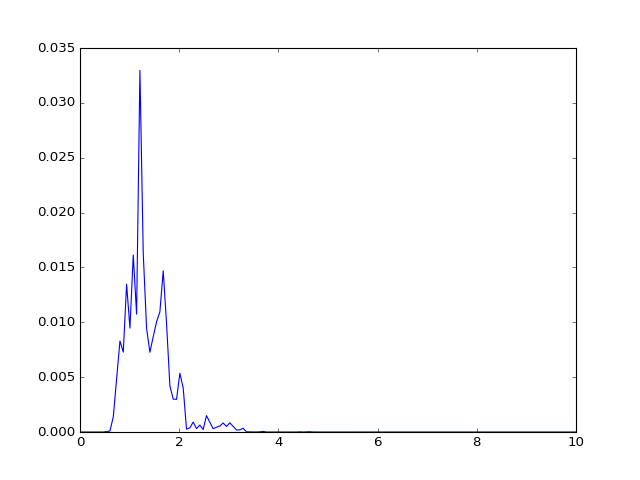

In [78]:
L = np.ones((len(n_list), len(z_list)))
k=3

x = np.genfromtxt(list[k])[:, 0]
y = np.genfromtxt(list[k])[:, 1]


for j in range(len(z_list)):
#         print(j)
        fitz = chi2(z_list[j], 1., lci, x, y, num_fil)
        for i in range(len(n_list)):
            #       print(i,j)
            L[i,j] = np.sum((flux_c - n_list[i]*fitz) ** 2 / (erflu_c ** 2))
            
H = np.amin(L, axis = 0)
PZ = H


plt.close()
plt.plot( z_list, np.exp(-(PZ)))
plt.show()

<IPython.core.display.Javascript object>


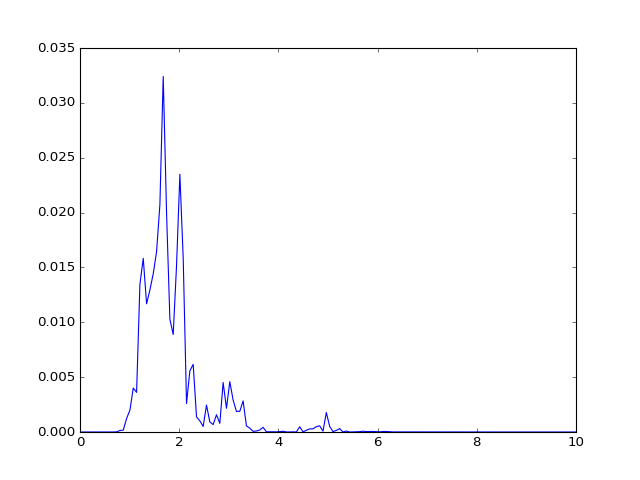

In [79]:
L = np.ones((len(n_list), len(z_list)))
k=4

x = np.genfromtxt(list[k])[:, 0]
y = np.genfromtxt(list[k])[:, 1]


for j in range(len(z_list)):
#         print(j)
        fitz = chi2(z_list[j], 1., lci, x, y, num_fil)
        for i in range(len(n_list)):
            #       print(i,j)
            L[i,j] = np.sum((flux_c - n_list[i]*fitz) ** 2 / (erflu_c ** 2))
            
H = np.amin(L, axis = 0)
PZ = H


plt.close()
plt.plot( z_list, np.exp(-(PZ)))
plt.show()

In [80]:
L = np.ones((5, len(n_list), len(z_list)))
print(np.shape(L))


# The main cycle
for k in range (L.shape[0]):
    # Data from template
    x = np.genfromtxt(list[k])[:, 0]
    y = np.genfromtxt(list[k])[:, 1]

    for j in range(len(z_list)):
#         print(j)
        fitz = chi2(z_list[j], 1., lci, x, y, num_fil)
        for i in range(len(n_list)):
            #       print(i,j)
            L[k,i,j] = np.sum((flux_c - n_list[i]*fitz) ** 2 / (erflu_c ** 2))
A = L[0,:,:]
B = L[1,:,:]
C = L[2,:,:]
D = L[3,:,:]
E = L[4,:,:]

Res = np.amin(L, axis=0)


(5, 200, 150)
29.4850173045 29.5451767355 29.5565817151 29.5069652359 29.5297010974
29.4850173045


In [87]:
Res
K = np.amin(Res, axis = 0)
print(K)

[ 18.42306723  19.70206048  16.77042973  17.72573528  16.11624108
  11.86332166  11.96865187  11.98795449   8.27107411   7.75803873
   5.35783606   4.44257655   4.04010292   4.38041481   4.10339221
   4.45925711   3.81521166   4.28410903   3.38171151   3.86126622
   4.44946123   4.34676946   4.23879918   4.10885407   3.87666112
   3.42956316   3.91253888   4.57727181   4.72325464   4.18855465
   3.751041     4.14388137   5.95502801   5.1896157    5.089125
   6.38162174   6.88811817   7.5882659    6.00903967   6.92375672
   7.29957116   6.45290457   7.10729943   5.40097887   6.13827979
   5.38407698   5.83978759   6.27770319   6.27298811   5.86586922
   7.49116998   7.95241357   9.66677135   9.28068412   8.59557663
   7.75701734  11.02694787  10.81459134  10.72395251  11.15693819
  10.15344292   9.68043903  10.57656678  10.32569384   8.64887034
  14.7337842    4.76295506   5.12118241   4.07504862   3.68027901
   4.42633268   4.14828324   4.93479269   3.98070095   4.41539848
   3.8994134

<IPython.core.display.Javascript object>


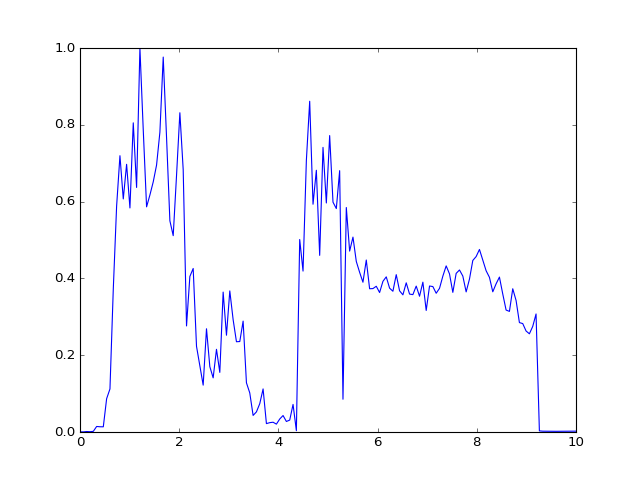

In [86]:
plt.close()
plt.plot( z_list, np.exp(-0.5*(K - min(K))))
plt.show()